XGBoost    ~Jyosna Philip

In [3]:
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score,root_mean_squared_error #Additional scklearn functions
from sklearn.model_selection import GroupShuffleSplit,GridSearchCV

In [2]:
x_train = pd.read_csv("C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\XTrain.csv")
y_train = pd.read_csv("C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\YTrain.csv")
engine = np.array(pd.read_csv("C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\Engine.csv"))

In [3]:
Engine=engine.ravel()

xg boost -base model

In [12]:
gss_b = GroupShuffleSplit(n_splits = 1, train_size = 0.7, random_state = 42)
train_index_b,val_index_b=next(gss_b.split(x_train, y_train, engine))
Y_train=np.asarray(y_train).ravel()
xgb_b = XGBRegressor(n_estimators=70, max_depth=8, eta=0.2, subsample=0.7, colsample_bytree=0.8)
xgb_b.fit(x_train.iloc[train_index_b,:], Y_train[train_index_b])
prediction=xgb_b.predict(x_train.iloc[val_index_b,:])
print(r2_score( Y_train[val_index_b],prediction))
print(root_mean_squared_error( Y_train[val_index_b],prediction))

0.6388315862709321
39.16098501762964


0.6388315862709321

39.16098501762964

xgb with cv

In [13]:
gss_outer = GroupShuffleSplit(n_splits = 10, train_size = 0.7, random_state = 42) #n_splits refers to number of folds required
r2=[]
rmse=[]
for i, (train_index, val_index) in enumerate(gss_outer.split(x_train, y_train, Engine)):
    xtrain = x_train.iloc[train_index, :] # Train Data from training set (70% split)
    ytrain = y_train.iloc[train_index, :]
    Y_train=np.asarray(ytrain).ravel()
    xval = x_train.iloc[val_index, :] # Validation Data from training set (30% split)
    yval = y_train.iloc[val_index, :]
    
    xgb_cv =XGBRegressor(n_estimators=100, max_depth=7, eta=0.1)
    xgb_cv.fit(xtrain, Y_train)
    r2.append(r2_score( yval,xgb_cv.predict(xval)))
    rmse.append(root_mean_squared_error(yval,xgb_cv.predict(xval)))
print('R2: %.3f (%.3f)' % (np.mean(r2), np.std(r2)))
print('RMSE: %.3f (%.3f)' % (np.mean(rmse), np.std(rmse)))


R2: 0.617 (0.053)
RMSE: 42.284 (3.890)


R2: 0.617 (0.053)

RMSE: 42.284 (3.890)

xgb with gridsearch

In [17]:
gss_grid =  GroupShuffleSplit(n_splits = 1, train_size = 0.7, random_state = 42)

xgb_grid = XGBRegressor(seed=42)
para={"learning_rate":[0.05,0.1,0.2],"n_estimators":[70,100,200,300],"max_depth":[5,6,7,8],"min_child_weight":[50,100] }
train_index_grid,val_index_grid=next(gss_grid.split(x_train, y_train, Engine))
# define search
search = GridSearchCV(xgb_grid, param_grid=para, scoring=['r2','neg_root_mean_squared_error'], cv=gss_grid, refit='r2')
# execute search
Y_train=np.asarray(y_train).ravel()
result = search.fit(x_train.iloc[train_index_grid,:], Y_train[train_index_grid],groups=Engine[train_index_grid])
# get the best performing model fit on the whole training set
best_model = result.best_estimator_
yhat = best_model.predict(x_train.iloc[val_index_grid,:])
# evaluate the model
r2 = r2_score(Y_train[val_index_grid], yhat)
rmse=root_mean_squared_error(Y_train[val_index_grid],yhat)
print("r2: ",r2)
print("rmse: ",rmse)

r2:  0.7051736007072658
rmse:  35.3819618955303


r2:  0.7051736007072658

rmse:  35.3819618955303

In [18]:
result.best_params_

{'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 100,
 'n_estimators': 70}

{'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 100,
 'n_estimators': 70}

gradient boosting with gridsearch cv

In [22]:
gss_grid_cv =  GroupShuffleSplit(n_splits = 10, train_size = 0.7, random_state = 42)

xgb_grid_cv =XGBRegressor(seed=42)
para={"learning_rate":[0.05,0.1,0.2],"n_estimators":[70,100,200,300],"max_depth":[5,6,7,8],"min_child_weight":[70,100,150,200] }
train_index_grid_cv,val_index_grid_cv=next(gss_grid_cv.split(x_train, y_train, Engine))
# define search
search = GridSearchCV(xgb_grid_cv, param_grid=para, scoring=['r2','neg_root_mean_squared_error'], cv=gss_grid_cv, refit='r2')
# execute search
Y_train=np.asarray(y_train).ravel()
result = search.fit(x_train.iloc[train_index_grid_cv,:], Y_train[train_index_grid_cv],groups=Engine[train_index_grid_cv])
# get the best performing model fit on the whole training set
best_model = result.best_estimator_
print(result.best_params_)
yhat = best_model.predict(x_train.iloc[val_index_grid_cv,:])
# evaluate the model
r2 = r2_score(Y_train[val_index_grid_cv], yhat)
rmse=root_mean_squared_error(Y_train[val_index_grid_cv],yhat)
print("r2: ",r2)
print("rmse: ",rmse)

{'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70}
r2:  0.7017800607793739
rmse:  35.585007763032074


{'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70}

r2:  0.7017800607793739

rmse:  35.585007763032074

In [23]:
import pickle
pickle.dump(best_model, open('xgb_model.pkl','wb'))

gradient boosting with nested gridsearchcv

In [24]:
gss_outer = GroupShuffleSplit(n_splits = 10, train_size = 0.7, random_state = 42) #n_splits refers to number of folds required

# enumerate splits
outer_results = {"r2":[],"rmse":[]}
for i,(train_ix, test_ix) in enumerate(gss_outer.split(x_train, y_train, engine)):
    # split data
    X_train, X_test = x_train.iloc[train_ix, :], x_train.iloc[test_ix, :]
    Y_train, Y_test = y_train.iloc[train_ix], y_train.iloc[test_ix]
    Engine=engine[train_ix]
    Y_train=np.asarray(Y_train).ravel()
    Engine=Engine.ravel()
    # configure the cross-validation procedure
    gss_inner =  GroupShuffleSplit(n_splits = 3, train_size = 0.7, random_state = 42)
    # define the model
    xgb = XGBRegressor(seed=42)
    para={"learning_rate":[0.05,0.1,0.2],"n_estimators":[70,100,200,300],"max_depth":[5,6,7,8],"min_child_weight":[70,100,150,200] }

    # define search
    search = GridSearchCV(xgb, param_grid=para, scoring=['r2','neg_root_mean_squared_error'], cv=gss_inner, refit='r2')
    # execute search
    result = search.fit(X_train, Y_train,groups=Engine)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    r2 = r2_score(Y_test, yhat)
    rmse=root_mean_squared_error(Y_test,yhat)
    # store the result
    outer_results["r2"].append(r2)
    outer_results["rmse"].append(rmse)
    # report progress
    print('>r2=%.3f, est=%.3f, cfg=%s' % (r2, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('R2: %.3f (%.3f)' % (np.mean(outer_results["r2"]), np.std(outer_results["r2"])))
print('RMSE: %.3f (%.3f)' % (np.mean(outer_results["rmse"]), np.std(outer_results["rmse"])))

>r2=0.702, est=0.593, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70}
>r2=0.603, est=0.688, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 150, 'n_estimators': 70}
>r2=0.709, est=0.629, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70}
>r2=0.749, est=0.544, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70}
>r2=0.695, est=0.621, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70}
>r2=0.641, est=0.628, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 100, 'n_estimators': 70}
>r2=0.694, est=0.592, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70}
>r2=0.648, est=0.676, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70}
>r2=0.607, est=0.769, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70}
>

>r2=0.702, est=0.593, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70}

>r2=0.603, est=0.688, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 150, 'n_estimators': 70}

>r2=0.709, est=0.629, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70}

>r2=0.749, est=0.544, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70}

>r2=0.695, est=0.621, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70}

>r2=0.641, est=0.628, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 100, 'n_estimators': 70}

>r2=0.694, est=0.592, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70}

>r2=0.648, est=0.676, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70}

>r2=0.607, est=0.769, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70}

>r2=0.594, est=0.743, cfg={'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 200, 'n_estimators': 70}

R2: 0.664 (0.050)
RMSE: 39.547 (3.804)

In [1]:
import pickle 
model = pickle.load(open('xgb_model.pkl','rb'))

In [4]:
xtest_data = pd.read_csv('C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\XTest.csv')
ytest_data  = pd.read_csv('C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\Ytest.csv')
engine_test_data = pd.read_csv('C:\\Users\\jyosn\\Documents\\GitHub\\Predictive-Maintenance\\Datasets\\ForModelDev\\Engine_test.csv')

In [5]:
ypred = model.predict(xtest_data)
print("Testing accuracy: ")
print('RMSE: ',root_mean_squared_error(ytest_data, ypred))
print('R2: ' ,r2_score(ytest_data, ypred))

Testing accuracy: 
RMSE:  47.4330264304722
R2:  0.3531797350836612


Testing accuracy: 

RMSE:  47.4330264304722

R2:  0.3531797350836612

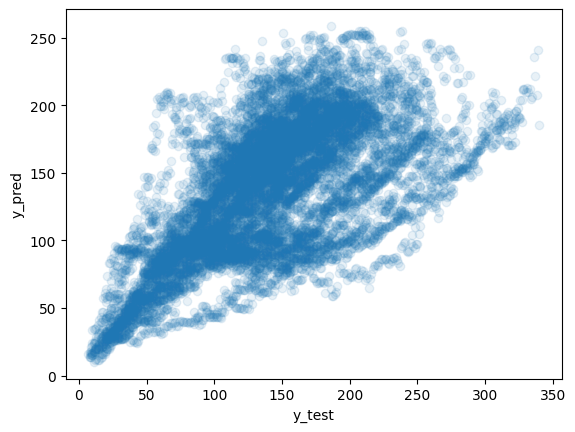

In [6]:
import matplotlib.pyplot as plt
fig=plt.figure()
plt.scatter(ytest_data,ypred,alpha=0.1,marker="o")
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()
